## General Local States Example

For reference, look in these papers: \[Baur, Räth 2021, PRR in review\]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rescomp
from rescomp.simulations import simulate_trajectory

#### Sim Data Params

In [2]:
ks_dim = 40  # 40 or 64
ks_size = 22  # 22
ks_dt = 0.5  # 0.05

shuffle = False
disc_ts = int(1e4)
sync_ts = int(2e3)
train_ts = int(2e4)
pred_ts = int(1e3)

tot_ts = disc_ts + 2 * sync_ts + train_ts + pred_ts

# nrmse_normalization = "maxmin"
# noise_only_to_training_data = True

#### Simulation

In [3]:
np.random.seed(1)
ks_signal = simulate_trajectory(
    sys_flag="kuramoto_sivashinsky", dimensions=ks_dim,
    system_size=ks_size, dt=ks_dt, time_steps=tot_ts)

#### Plot

Text(0, 0.5, 'Dimension')

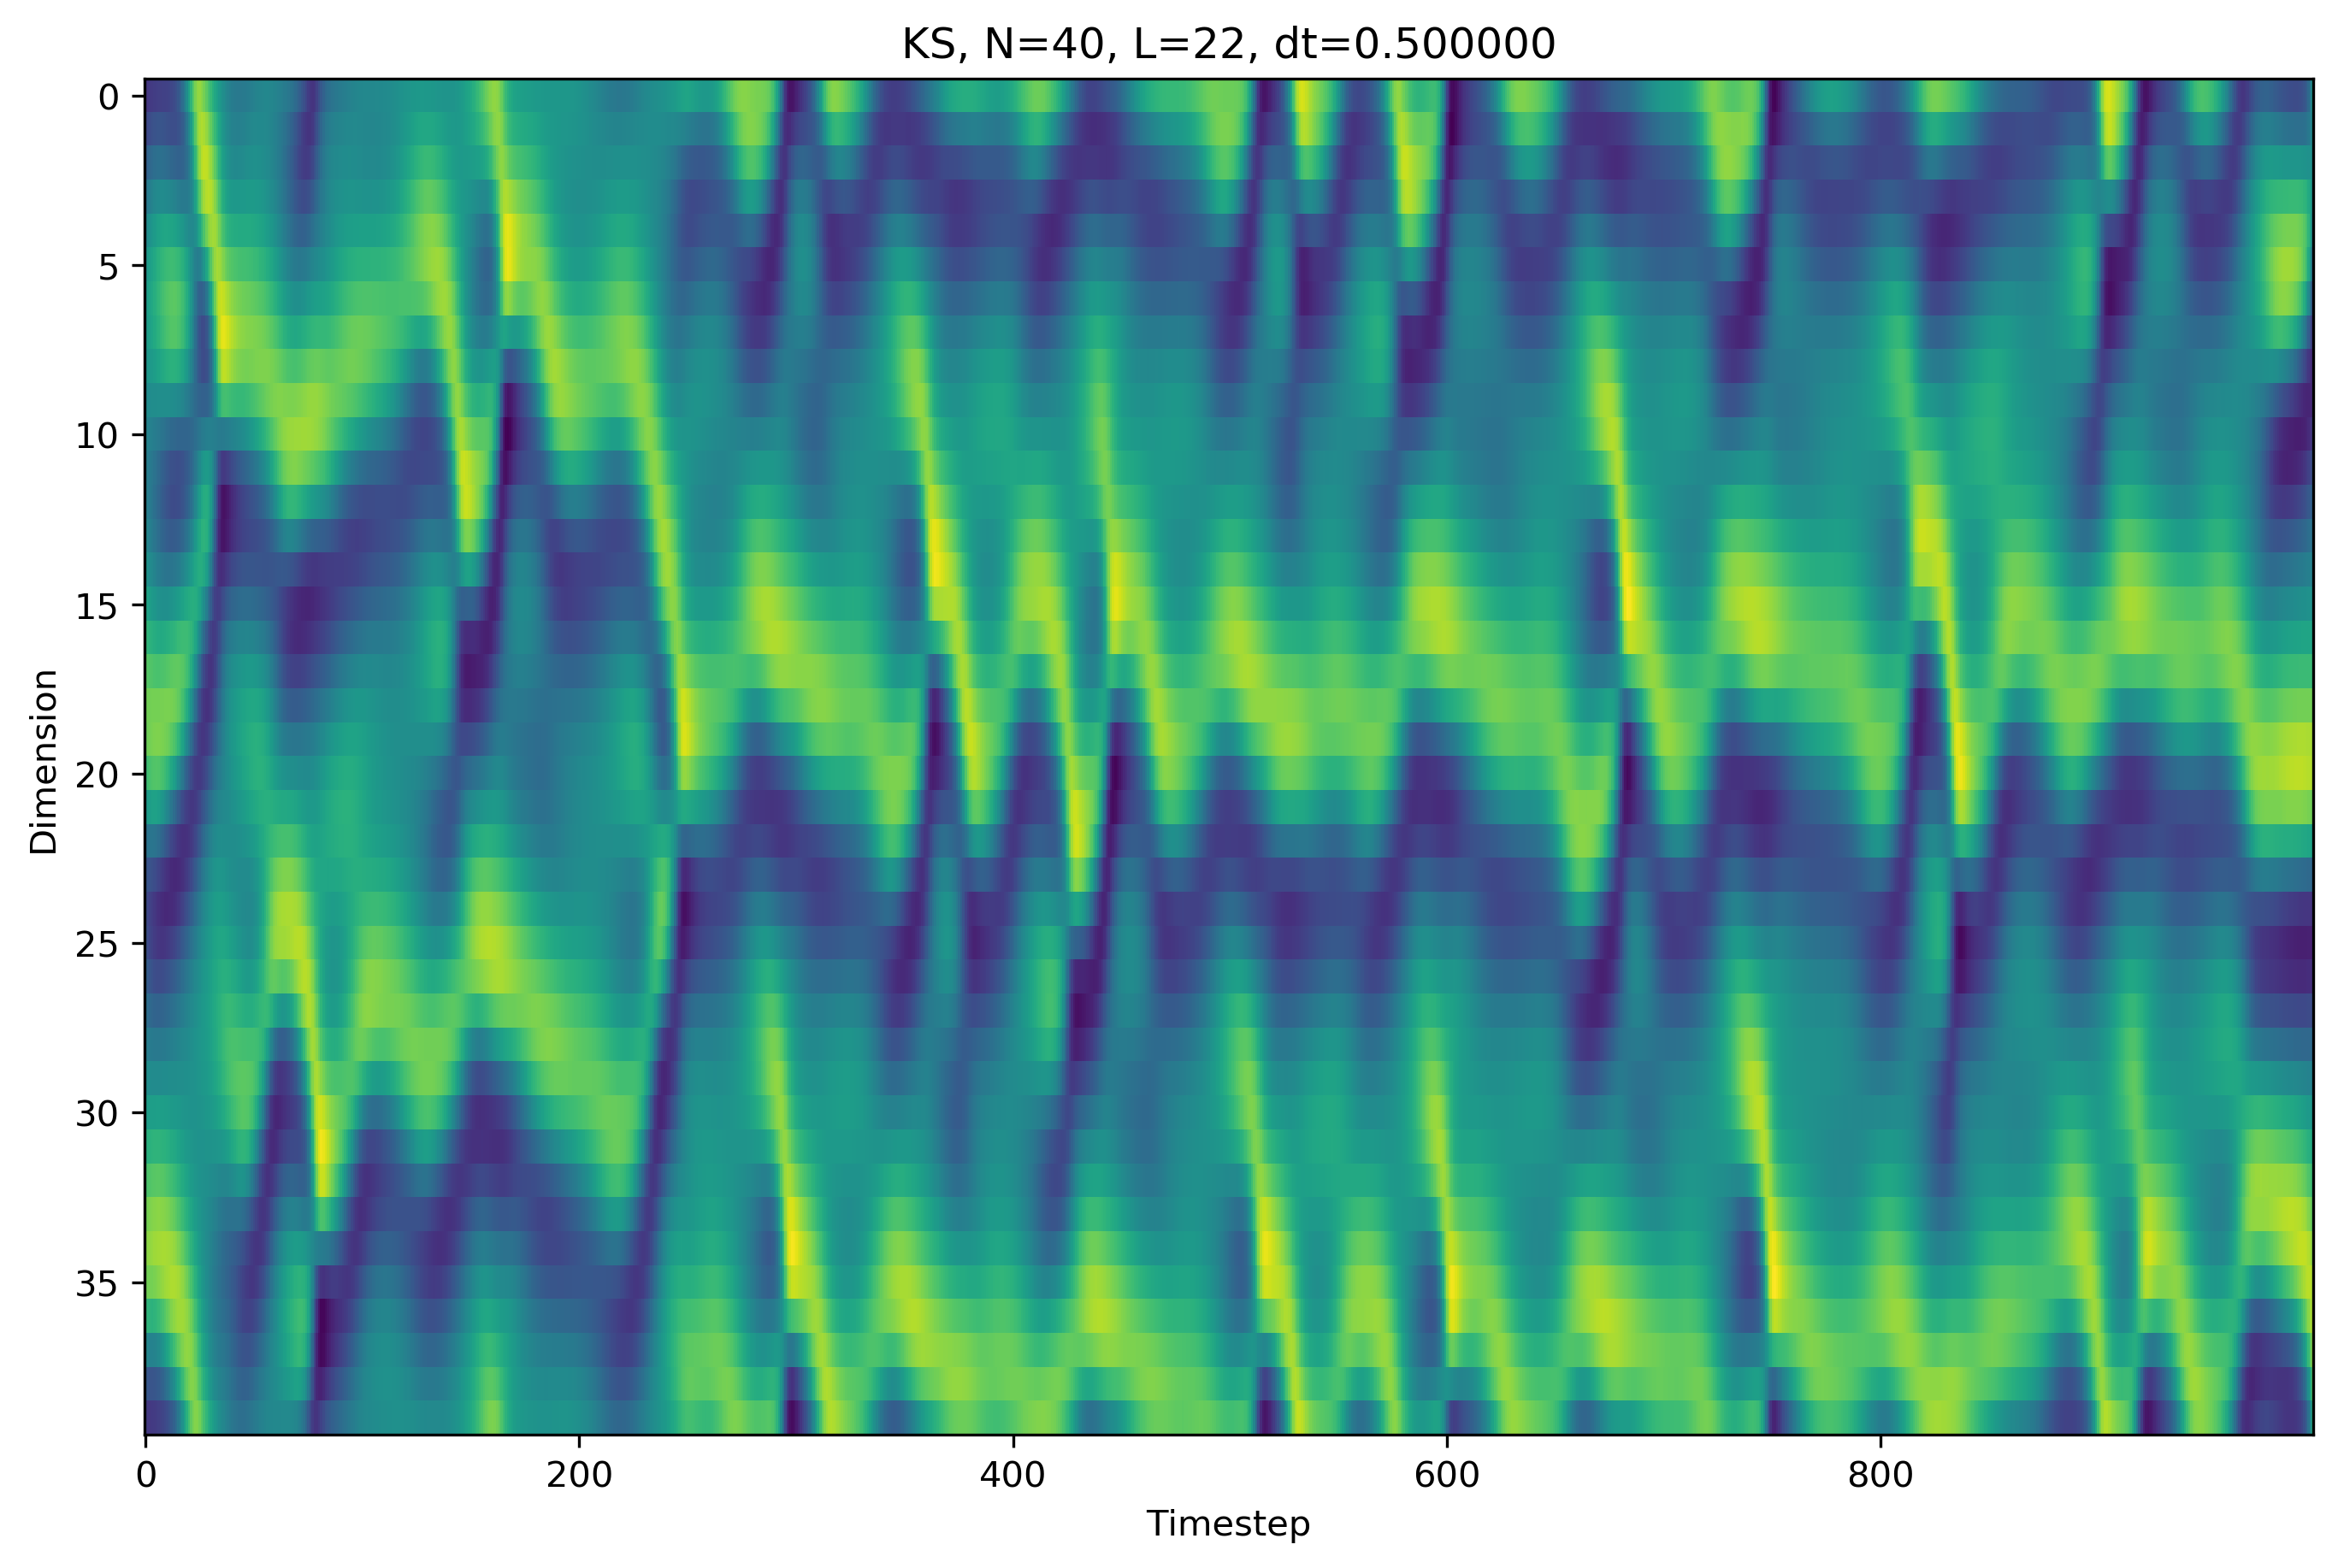

In [4]:
ks_title = "KS, N=%d, L=%d, dt=%f"%(ks_dim, ks_size, ks_dt)
# ks_title = hf.format_floats_in_str(ks_title)
# ks_file_name = ks_title

ks_axis_ranges = [-pred_ts, tot_ts]

ks_xlabel = "Timestep"
ks_ylabel = "Dimension"

signal_raw = ks_signal
y_test = ks_signal[ks_axis_ranges[0]: ks_axis_ranges[1]]

fig, ax = plt.subplots(1, 1, figsize=(9, 6), constrained_layout=True, dpi=300)

vmin = np.min(y_test)
vmax = np.max(y_test)

im = ax.imshow(y_test.T, aspect='auto', vmin=vmin, vmax=vmax)

ax.set_title(ks_title)
ax.set_xlabel(ks_xlabel)
ax.set_ylabel(ks_ylabel)

#### Add noise to training data

In [5]:
noise_scale = 1e-2

ts_until_train_end = disc_ts + sync_ts + train_ts
noise = np.random.normal(scale=noise_scale, size=[ts_until_train_end, signal_raw.shape[1]])
signal = np.copy(signal_raw)
# hf.debug(signal[noise.shape[0]-2: noise.shape[0]+2, 0])
signal[:noise.shape[0]] = signal[:noise.shape[0]] + noise
# hf.debug(signal[noise.shape[0]-2: noise.shape[0]+2, 0])

# signal = signal_raw

Localities

In [6]:
# # SN
sn_loc_matrix = rescomp.locality_measures.sn_loc(signal)
cc_loc_matrix = rescomp.locality_measures.cc_loc(signal)
nmi_loc_matrix = rescomp.locality_measures.nmi_loc(signal)


#### Neighborhoods from Locality Matrix

In [7]:
nbs = 18 # Nr. of neighbors in each neighborhood

sn_nbhds = rescomp.locality_measures.find_local_neighborhoods(
                sn_loc_matrix, neighbors=nbs)
cc_nbhds = rescomp.locality_measures.find_local_neighborhoods(
                cc_loc_matrix, neighbors=nbs)
nmi_nbhds = rescomp.locality_measures.find_local_neighborhoods(
                nmi_loc_matrix, neighbors=nbs)

#### Plotting helper function

In [8]:
import matplotlib.patches as mpatches

def force_colorbar_legend(ax, im, labels, label_values):
    label_colors = [im.cmap(im.norm(value)) for value in label_values]

    patches = [mpatches.Patch(label=labels[i], color=label_colors[i])
               for i in range(len(label_values))]

    ax.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2,
              borderaxespad=0.)

#### Plot Neighborhoods

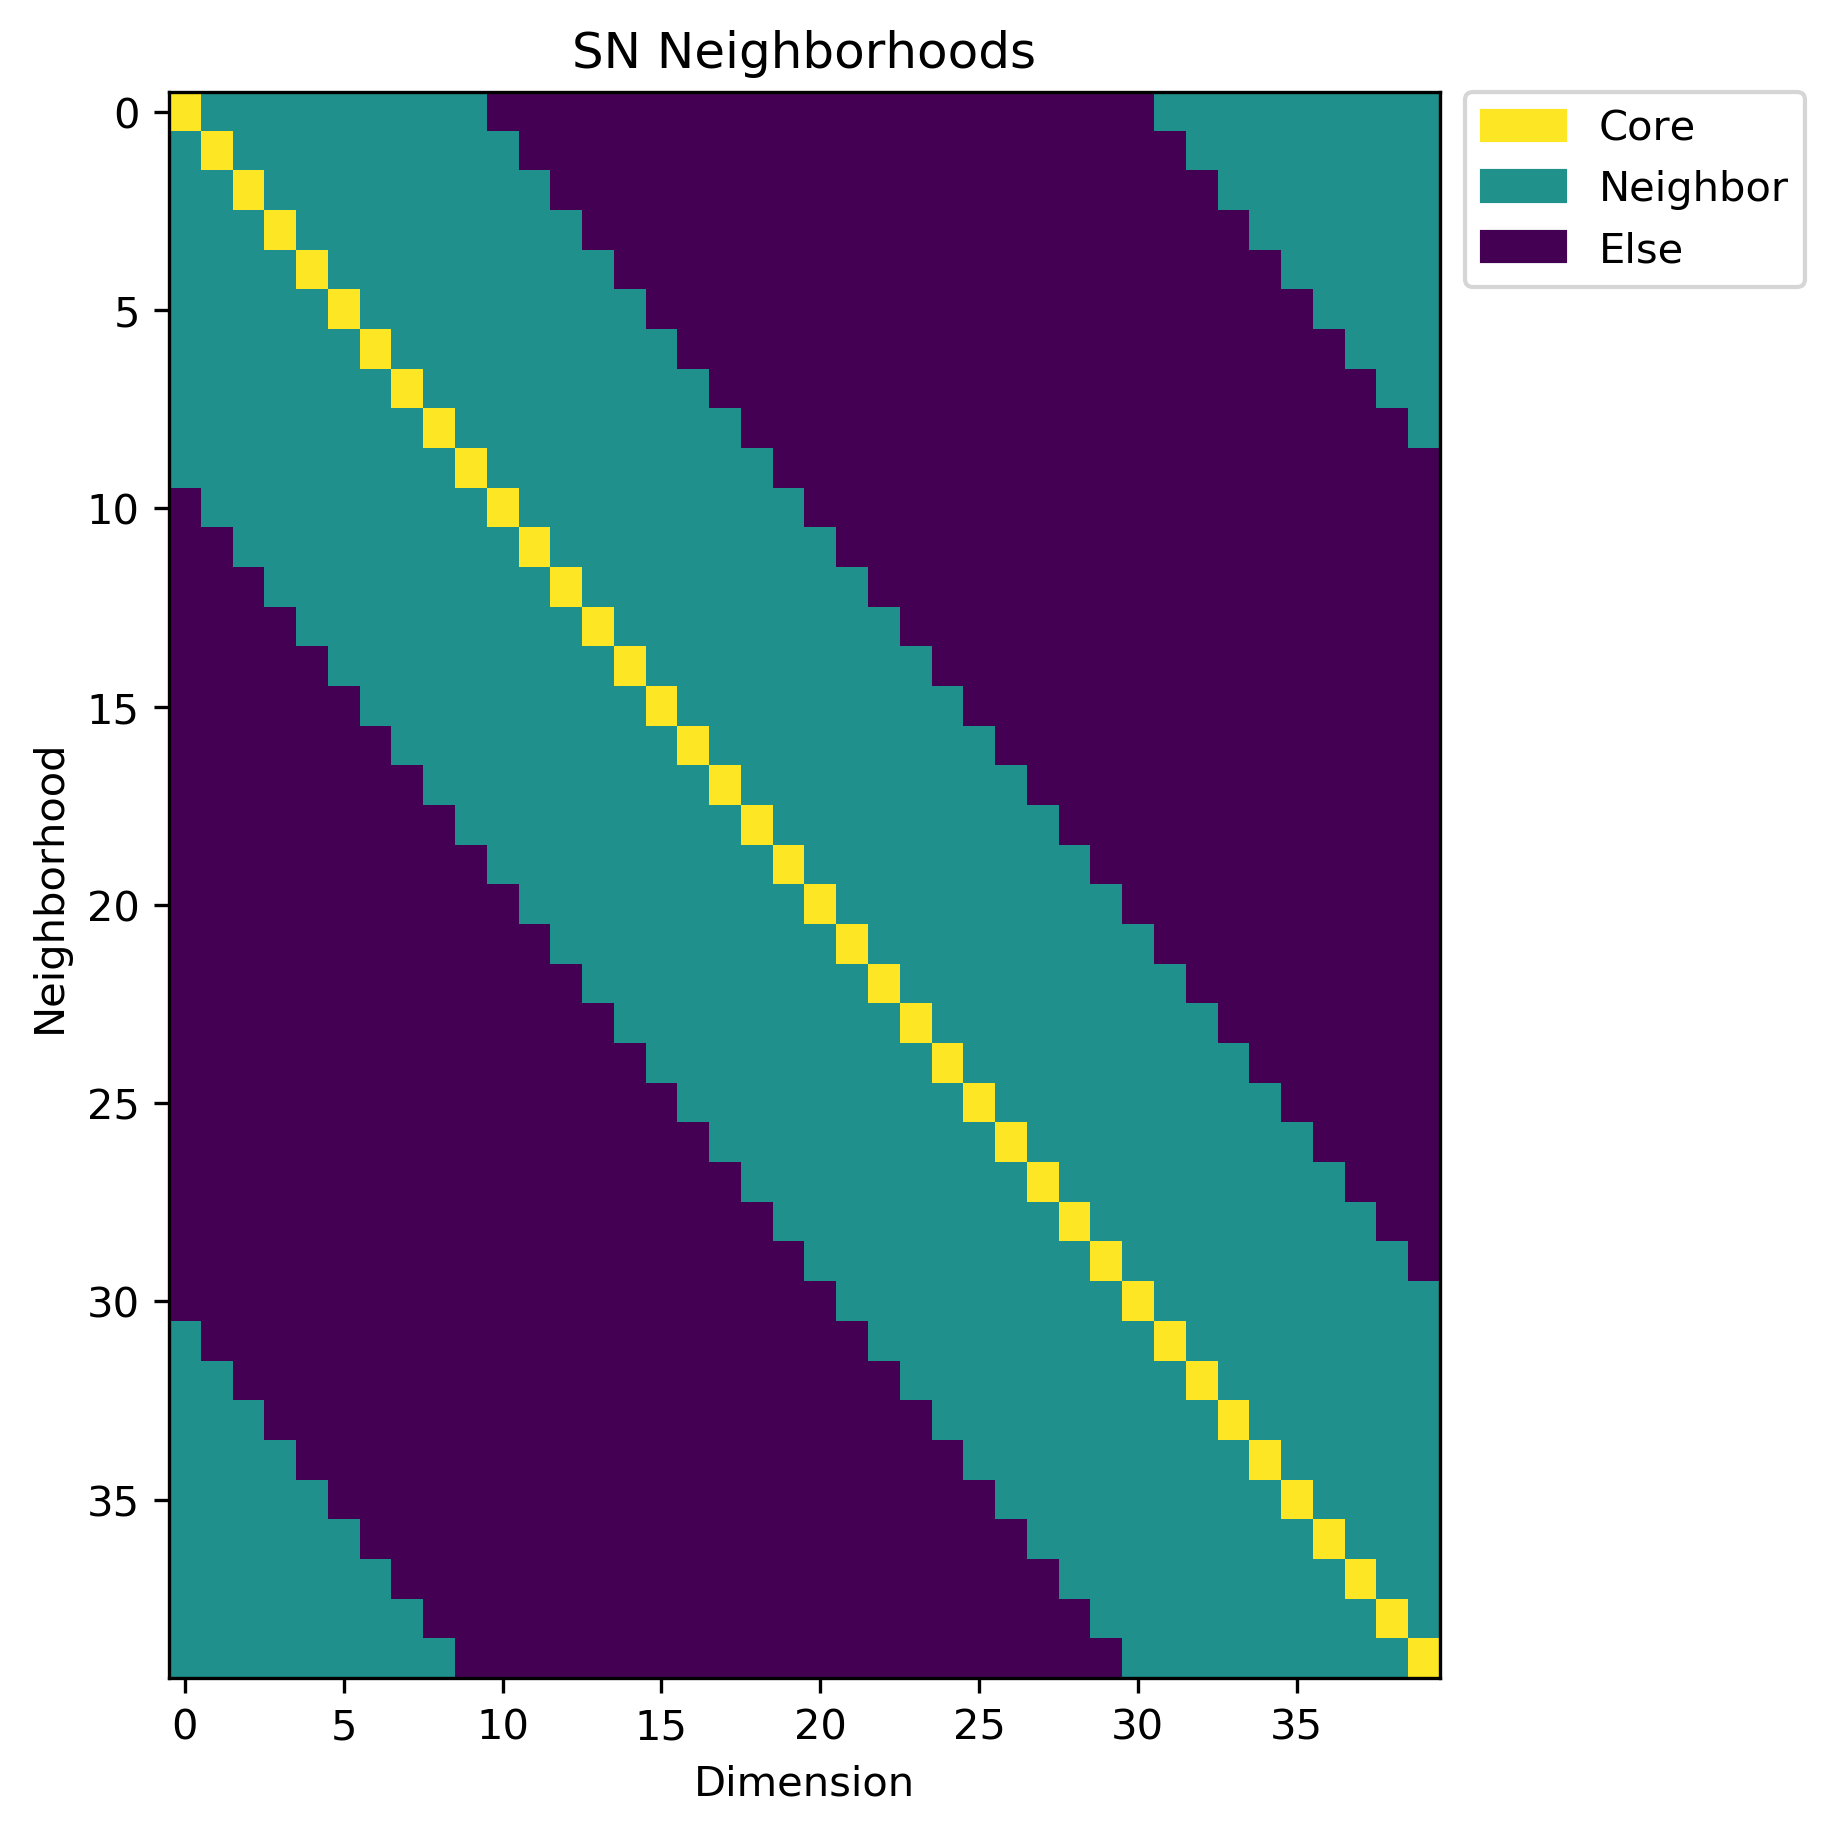

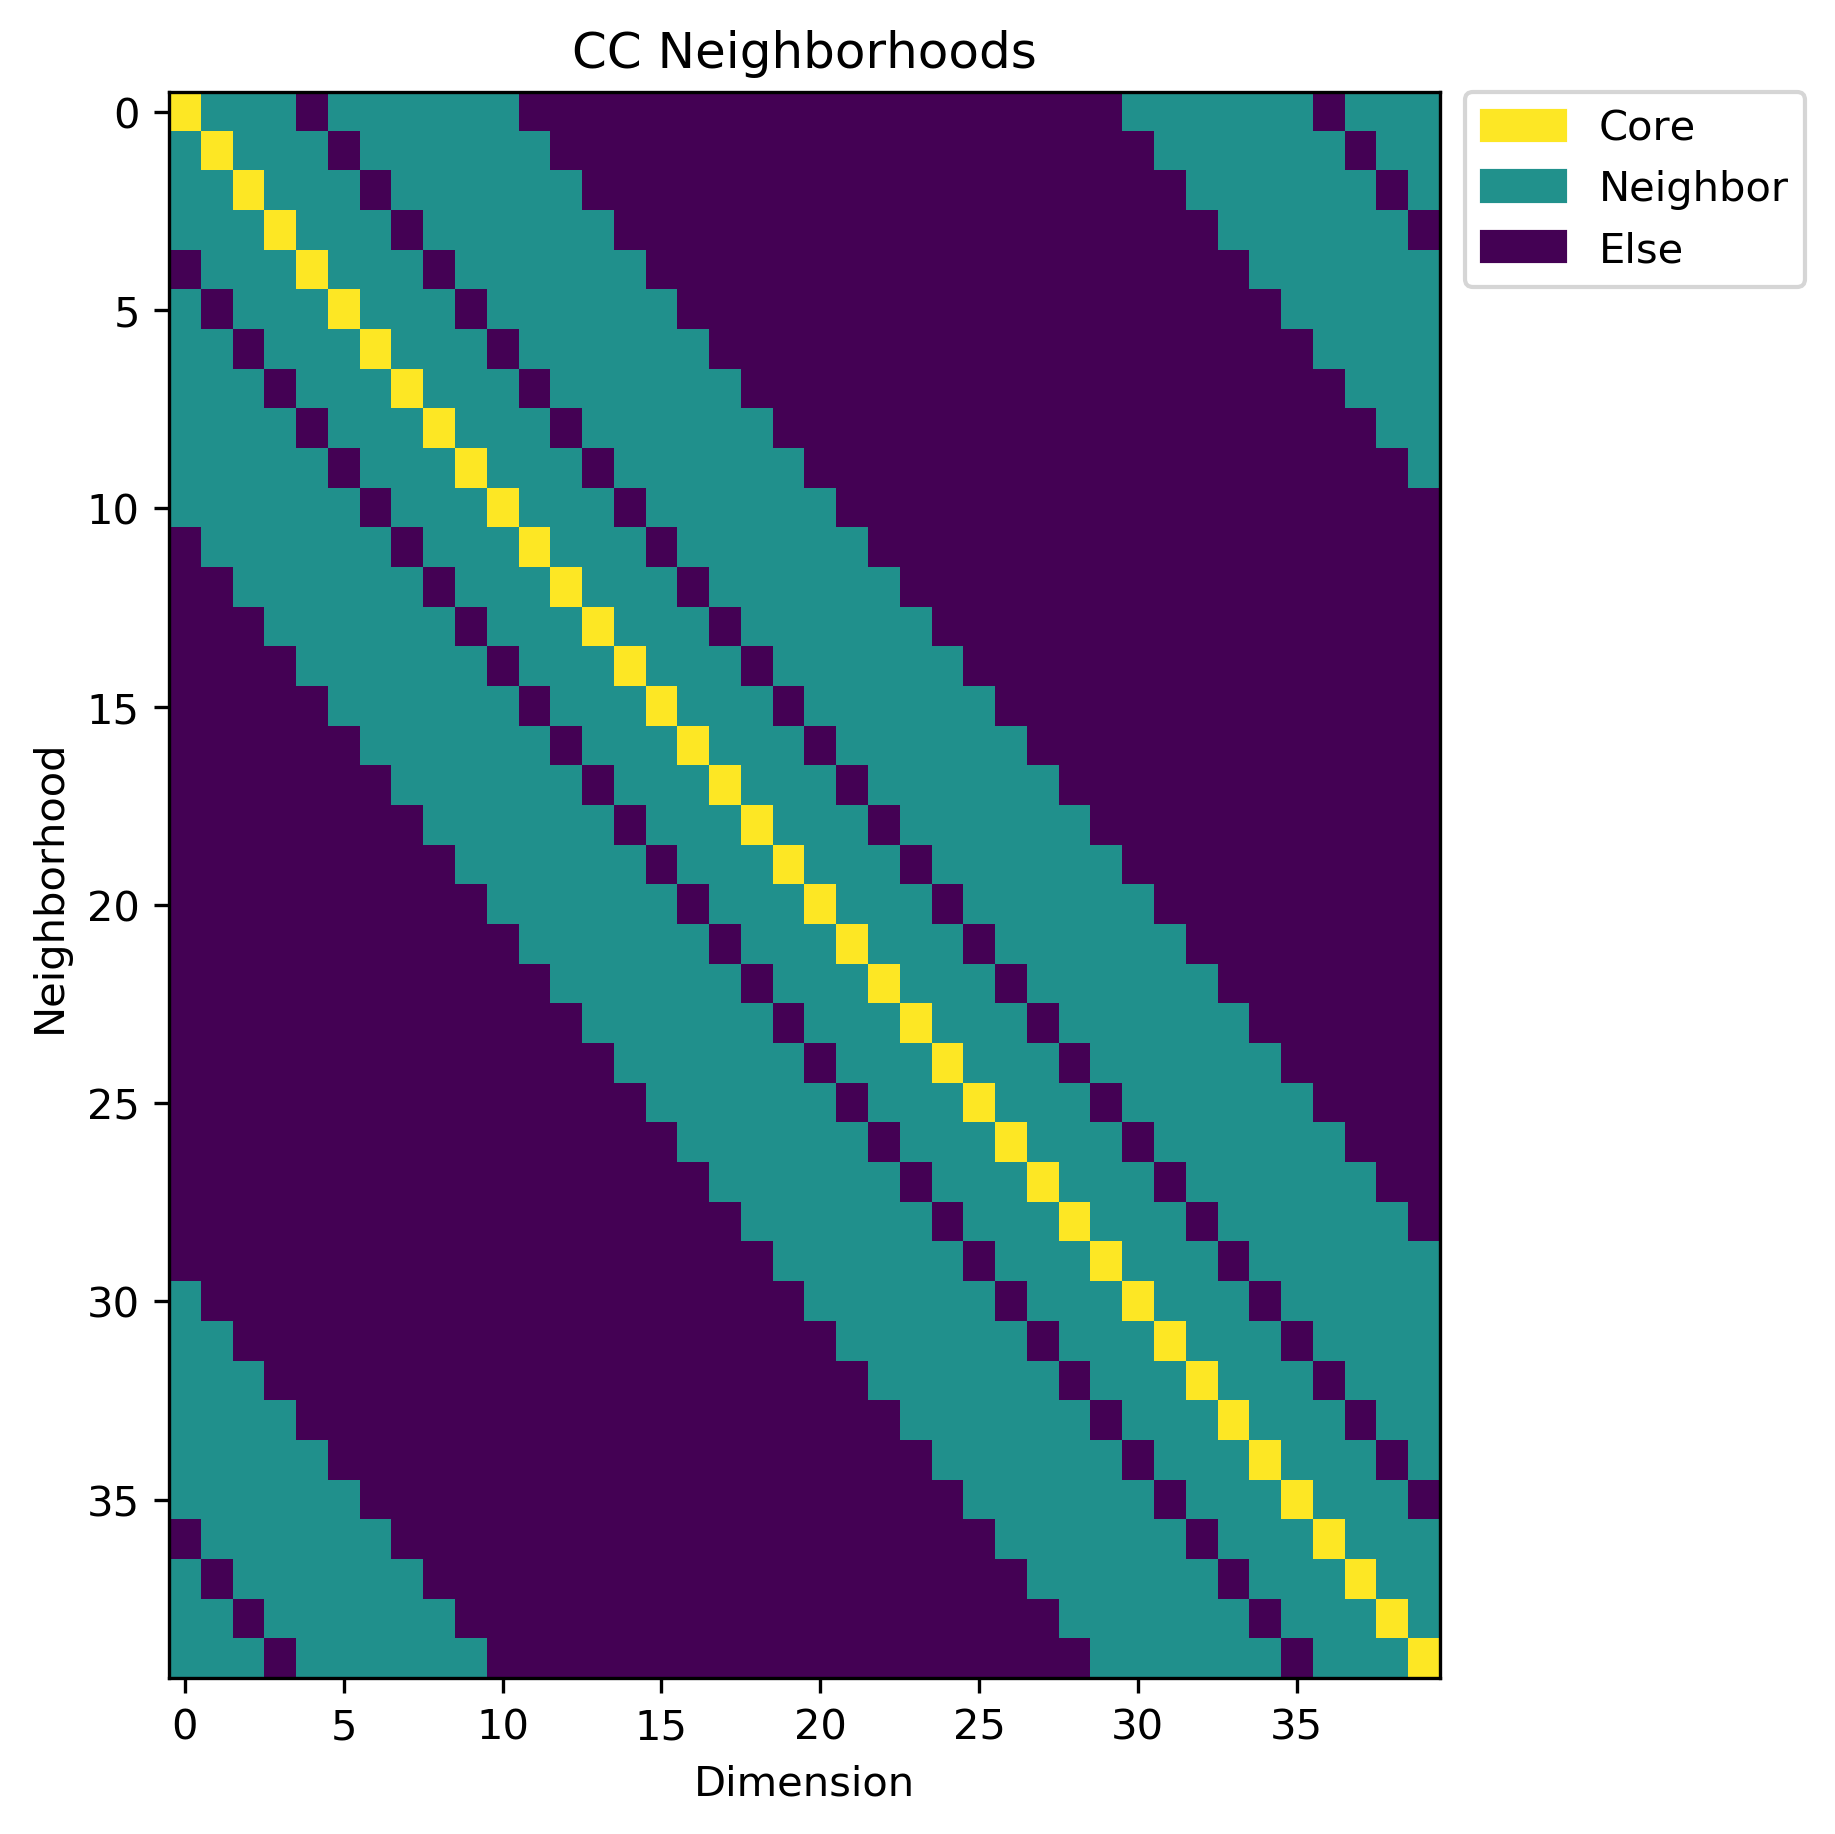

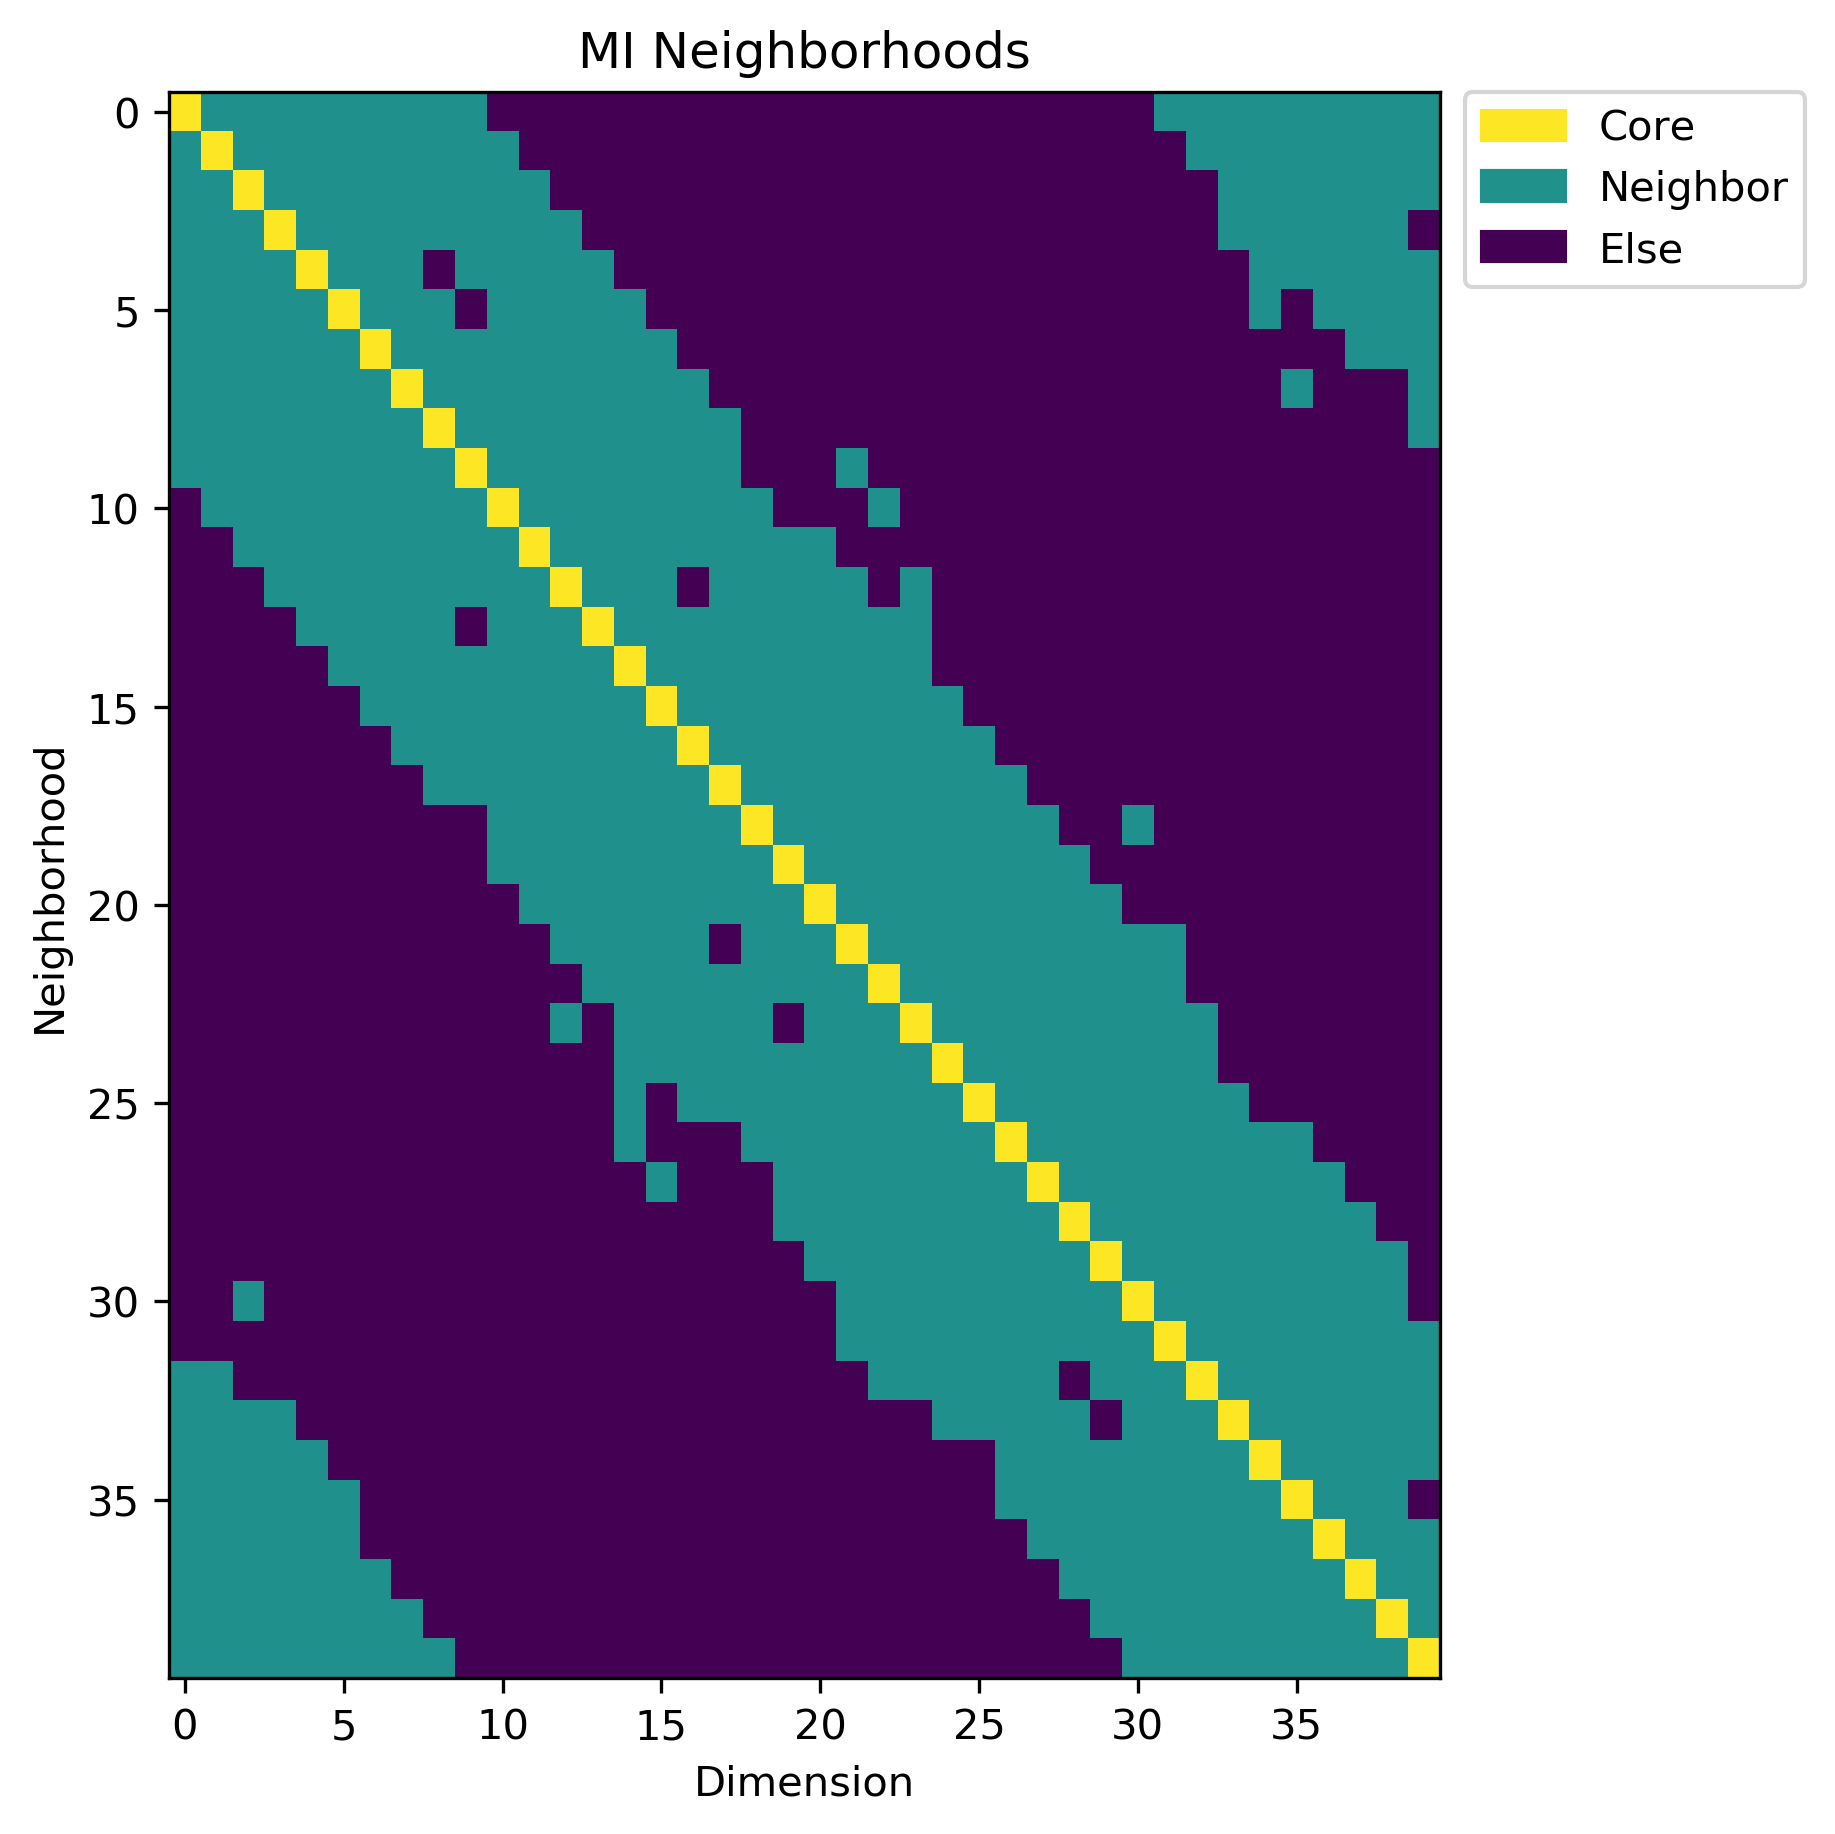

In [9]:
titles = ["SN Neighborhoods", "CC Neighborhoods", "MI Neighborhoods"]
nbhds = [sn_nbhds, cc_nbhds, nmi_nbhds]

for i in range(3):
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True, dpi=300)
    
    # vmin = np.min(y_test)
    # vmax = np.max(y_test)
    
    im = ax.imshow(nbhds[i], aspect='auto')
    
    ax.set_title(titles[i])
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Neighborhood")
    
    labels = ['Core', 'Neighbor', 'Else']
    label_values = [2, 1, 0]
    
    force_colorbar_legend(ax, im, labels, label_values)


#### Choose Neighborhoods to use for the ESN

In [10]:
loc_nbhds = sn_nbhds
# loc_nbhds = cc_nbhds
# loc_nbhds = mi_nbhds

#### Create, Train, Predict with ESN 

In [ ]:
n_dim = 3000
w_out_fit_flag = "linear_and_square_r"
avg_degree = 3
regularization = 1e-6
spectral_radius = 0.5
w_in_scale = 0.5
w_in_sparse = True
train_core_only = True

loc_esn = rescomp.esn.ESNGenLoc()
loc_esn.set_console_logger("DEBUG")

loc_esn.create_network(n_dim=n_dim,n_rad=spectral_radius, n_avg_deg=avg_degree)

y_pred, y_test = loc_esn.train_and_predict(
    x_data=signal,
    disc_steps=disc_ts,
    train_sync_steps=sync_ts,
    train_steps=train_ts,
    pred_sync_steps=sync_ts,
    loc_nbhds=loc_nbhds,
    reg_param=regularization,
    w_in_scale=w_in_scale,
    w_in_sparse=w_in_sparse,
    train_core_only=train_core_only,
    w_out_fit_flag=w_out_fit_flag
    )


11-23 11:13:46 [DEBUG  ] Start locality training with 40 neighborhoods
11-23 11:13:46 [DEBUG  ] Deepcopy initial ESN instance for each Neighborhood. Reservoir network matrix are shallow copies though.
11-23 11:13:46 [DEBUG  ] Start Training of Neighborhood 1/40
11-23 11:14:11 [DEBUG  ] Start Training of Neighborhood 2/40
11-23 11:14:30 [DEBUG  ] Start Training of Neighborhood 3/40
11-23 11:14:48 [DEBUG  ] Start Training of Neighborhood 4/40
11-23 11:15:12 [DEBUG  ] Start Training of Neighborhood 5/40
11-23 11:15:32 [DEBUG  ] Start Training of Neighborhood 6/40
11-23 11:15:51 [DEBUG  ] Start Training of Neighborhood 7/40


#### Plot the results

In [ ]:
fig, axs = plt.subplots(3, 1, sharex="all", figsize=(9, 6),
                            constrained_layout=True, dpi=300)

vmin = np.min(y_test)
vmax = np.max(y_test)

im = axs[0].imshow(y_test.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Simulation")

axs[1].imshow(y_pred.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Prediction")

axs[2].imshow(y_pred.T - y_test.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set_title("Difference between simulation and prediction")

axs[1].set_ylabel("dimension")
axs[2].set_xlabel("time steps")
fig.colorbar(im, ax=axs)
plt.show()
